In [1]:
## 导入包
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler # 多数样本下采样

# import import_ipynb
# from main_Resnet import ResidualBlock # 导入残差块

In [2]:
# 加载数据
data = np.load("./data_processed/data_norm.npy")
labels = np.load("./data_processed/labels.npy")  # 2139个负样本1，其余全是正样本0

In [4]:
## 降采样
data2 = data.reshape(30502, -1)
# 降采样策略
rus = RandomUnderSampler(sampling_strategy = {0: 2139})  # 将正常样本降采样到2139个

data_resample, labels_resample = rus.fit_resample(data2, labels)

data_resample = data_resample.reshape(-1, 16, 32, 16)
print([data_resample.shape, labels_resample.shape])

# # 将数据恢复为原来的形状
# X_normal_final = X_resampled[y_resampled == 0].reshape(-1, 32, 16)
# X_anomaly_final = X_resampled[y_resampled == 1].reshape(-1, 32, 16)

# # 检查最终数据的形状
# print(X_normal_final.shape)
# print(X_anomaly_final.shape)

[(4278, 16, 32, 16), (4278,)]


In [5]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1): # 指定输入通道，输出通道
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# # 输出示例
# x = torch.randn(64, 3, 32, 32)
# block = ResidualBlock(3, 64)
# out = block(x)
# print(out.shape)  # 输出：torch.Size([64, 64, 32, 32])


In [38]:
class ResNet_model(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet_model, self).__init__()
        self.conv1 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) # 输入为16个通道
        self.bn1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self._make_layer(8, 16, 2, stride=2) # 输入通道、输出通道、块数
        self.layer2 = self._make_layer(16, 32, 2, stride=2)
        self.layer3 = self._make_layer(32, 32, 2, stride=2)
        self.layer4 = self._make_layer(32, 64, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(64, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # 4层layer，每个layer有两个残差块
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        # x = self.fc1(x)
        x = self.fc2(x)
        return x

In [39]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet_model().to(device) # 实例化

In [40]:
summary(model, input_size=(1,16,32,16)) # 可视化网络结构

Layer (type:depth-idx)                   Output Shape              Param #
ResNet_model                             [1, 2]                    --
├─Conv2d: 1-1                            [1, 8, 32, 16]            1,160
├─BatchNorm2d: 1-2                       [1, 8, 32, 16]            16
├─ReLU: 1-3                              [1, 8, 32, 16]            --
├─Sequential: 1-4                        [1, 16, 16, 8]            --
│    └─ResidualBlock: 2-1                [1, 16, 16, 8]            --
│    │    └─Conv2d: 3-1                  [1, 16, 16, 8]            1,168
│    │    └─BatchNorm2d: 3-2             [1, 16, 16, 8]            32
│    │    └─ReLU: 3-3                    [1, 16, 16, 8]            --
│    │    └─Conv2d: 3-4                  [1, 16, 16, 8]            2,320
│    │    └─BatchNorm2d: 3-5             [1, 16, 16, 8]            32
│    │    └─Sequential: 3-6              [1, 16, 16, 8]            176
│    │    └─ReLU: 3-7                    [1, 16, 16, 8]            --
│    

In [41]:
# 将data和labels转换为 PyTorch 张量
data_tensor = torch.tensor(data_resample, dtype = torch.float32)
labels_tensor = torch.tensor(labels_resample, dtype = torch.long)
# 添加通道维度
# data_tensor = data_tensor.unsqueeze(1)  # 变为(num, 1, 32, 16)

# 创建 TensorDataset
dataset = TensorDataset(data_tensor, labels_tensor)

In [42]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = False)

In [43]:
## 训练模型
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
# 训练模型
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # 统计训练集的损失
        running_loss += loss.item() * x_train.size(0)
        
        # 统计训练集的准确率
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_train).sum().item()

    # 计算每个 epoch 的训练损失和准确率
    epoch_loss = running_loss / train_size
    epoch_accuracy = 100 * correct / train_size
    
    if epoch % 5 == 0 or epoch == num_epochs-1 :
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')
    
    ##------------ 每轮进行一次测试-----------
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            outputs = model(x_test)
            _, y_pred = torch.max(outputs, 1)
            test_correct += (y_pred == y_test).sum().item()

    test_accuracy = 100 * test_correct / test_size
    print(f'Test Accuracy: {test_accuracy:.2f}%')
        

Epoch [1/30]
Train Loss: 0.6637, Train Accuracy: 61.89%
Test Accuracy: 59.23%
Test Accuracy: 66.94%
Test Accuracy: 65.42%
Test Accuracy: 66.59%
Test Accuracy: 63.32%
Epoch [6/30]
Train Loss: 0.4959, Train Accuracy: 75.48%
Test Accuracy: 65.89%
Test Accuracy: 66.12%
Test Accuracy: 65.54%
Test Accuracy: 63.90%
Test Accuracy: 62.97%
Epoch [11/30]
Train Loss: 0.3602, Train Accuracy: 84.28%
Test Accuracy: 64.14%
Test Accuracy: 62.85%
Test Accuracy: 62.50%
Test Accuracy: 61.21%
Test Accuracy: 64.95%
Epoch [16/30]
Train Loss: 0.2444, Train Accuracy: 89.66%
Test Accuracy: 65.07%
Test Accuracy: 64.37%
Test Accuracy: 63.08%
Test Accuracy: 60.51%
Test Accuracy: 63.32%
Epoch [21/30]
Train Loss: 0.1873, Train Accuracy: 92.05%
Test Accuracy: 63.67%
Test Accuracy: 64.37%
Test Accuracy: 64.37%
Test Accuracy: 63.20%
Test Accuracy: 62.15%
Epoch [26/30]
Train Loss: 0.1592, Train Accuracy: 93.98%
Test Accuracy: 62.85%
Test Accuracy: 64.49%
Test Accuracy: 62.97%
Test Accuracy: 62.97%
Epoch [30/30]
Train Lo

In [45]:
# 测试模型
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, 1)
        test_correct += (y_pred == y_test).sum().item()

test_accuracy = 100 * test_correct / test_size
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 62.73%


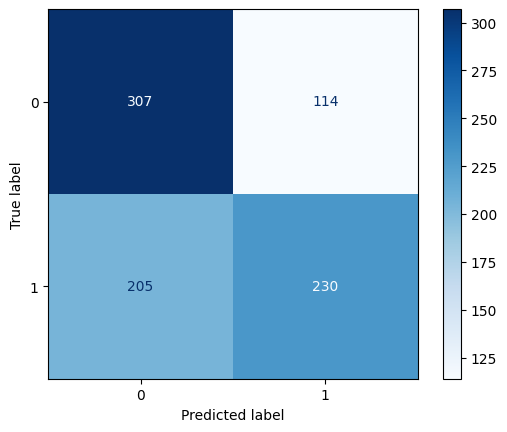

In [46]:
y_test, y_pred = y_test.cpu(), y_pred.cpu()
cm = confusion_matrix(y_test, y_pred)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()

In [24]:
## 计算Recall、pre
precision = precision_score(y_test, y_pred, pos_label = 1) # 指定阳性样本（正样本）
recall = recall_score(y_test, y_pred, pos_label = 1)
print([f"pre:", precision, f"recall:", recall])


['pre:', 0.6229116945107399, 'recall:', 0.6027713625866051]
